Mounted at /content/drive
8/8 [==============================] - 0s 2ms/step - loss: 0.1782 - accuracy: 0.9876
NNModel Test Loss: 0.1782
NNModel Test Accuracy: 98.76%
8/8 [==============================] - 0s 2ms/step

NNModel Classification Report:
              precision    recall  f1-score   support

        PRAD       0.95      0.98      0.96        42
        LUAD       1.00      1.00      1.00        40
        BRCA       0.99      1.00      0.99        90
        KIRC       1.00      1.00      1.00        41
        COAD       1.00      0.93      0.96        28

    accuracy                           0.99       241
   macro avg       0.99      0.98      0.98       241
weighted avg       0.99      0.99      0.99       241


SVMModel Classification Report:
              precision    recall  f1-score   support

        PRAD       1.00      1.00      1.00        42
        LUAD       1.00      1.00      1.00        40
        BRCA       1.00      1.00      1.00        90
        KIR

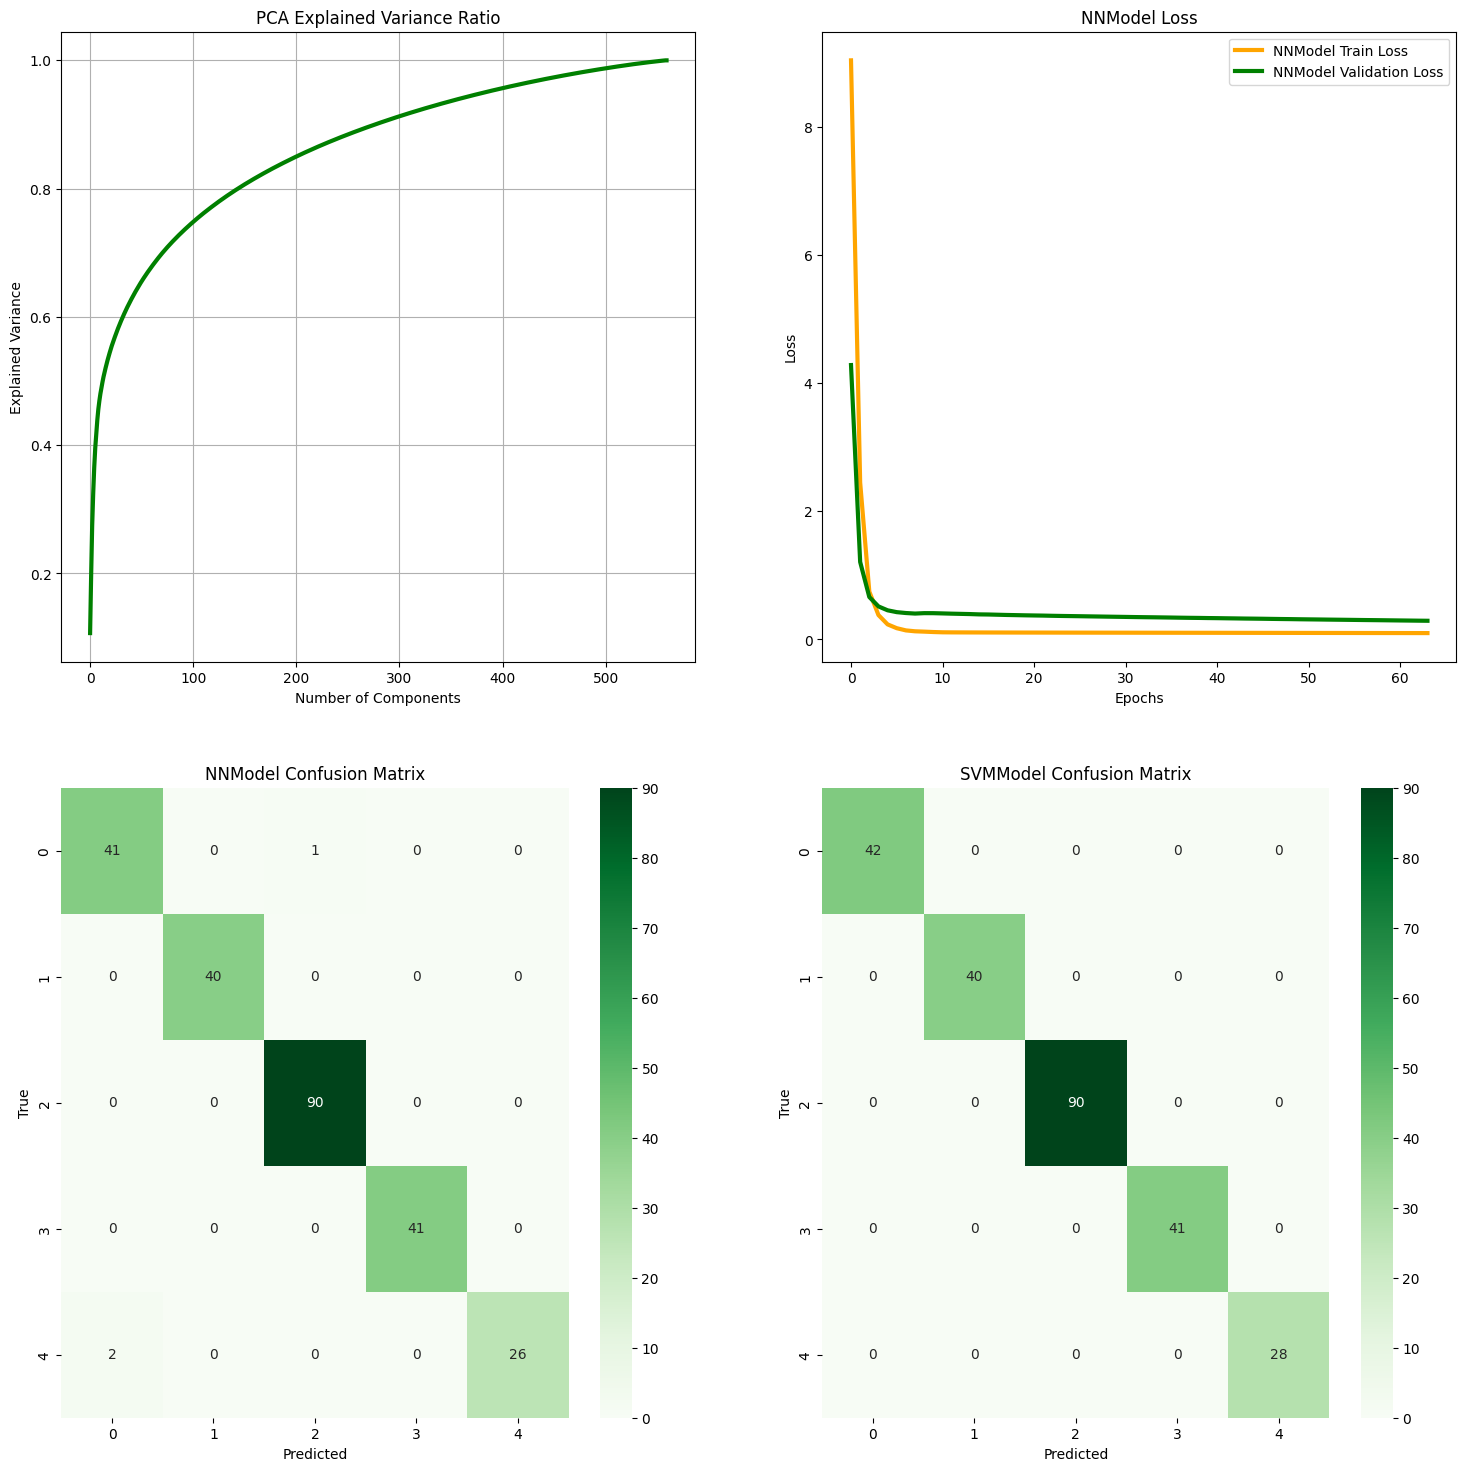

In [ ]:
# Aubrey Figueroa  October 10, 2023
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import keras
import logging
import os
import io

from pprint import pprint

import seaborn as sns

from keras import layers
from keras import regularizers
from keras import metrics

from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.svm import SVC

from google.colab import files
from google.colab import drive

drive.mount('/content/drive')

logging.basicConfig(filename='my_log.log', level=logging.INFO)

class DataProcessor:
    def __init__(self, data_path, labels_path):
        self.data = pd.read_csv(data_path)
        self.labels = pd.read_csv(labels_path)
        self._prepare_data()

    def _prepare_data(self)-> None:
        # Map Class labels to numeric values.
        label_mapping = {'PRAD': 0, 'LUAD': 1, 'BRCA': 2, 'KIRC': 3, 'COAD': 4}
        self.labels['Class'] = self.labels['Class'].replace(label_mapping)

        # Replace samples column in data with numerical class labels.
        self.data.rename(columns={'Unnamed: 0': 'Class'}, inplace=True)
        self.data['Class'] = self.labels['Class']

        # Separate inputs and features.
        X = self.data.drop(columns=['Class'])
        y = self.data['Class']

        # Split training and test data sets.
        self.X_train, self.X_test, self.y_train, self.y_test = train_test_split(X, y, test_size=0.3, random_state=42)

        self._scale_data()

    def _scale_data(self)-> None:
        # Standardize the data.
        scaler = StandardScaler()
        self.X_train_scaled = scaler.fit_transform(self.X_train)
        self.X_test_scaled = scaler.transform(self.X_test)

class PCAAnalyzer:
    def __init__(self, data_processor, num_components=50):
        self.num_components = num_components
        self.pca, self.X_train_pca, self.X_test_pca = self._perform_pca(data_processor)

    def _perform_pca(self, data_processor):
        # Perform PCA.
        pca = PCA()
        pca.fit(data_processor.X_train_scaled)
        fitted_pca = PCA(n_components=self.num_components)

        # Transform train and test features to PCA components.
        X_train_pca = fitted_pca.fit_transform(data_processor.X_train_scaled)
        X_test_pca = fitted_pca.transform(data_processor.X_test_scaled)

        return pca, X_train_pca, X_test_pca

class Plotter:
    @staticmethod
    def plot_combined_results( pca, nn_history, nn_model, svm_model ):
        fig, axs = plt.subplots( 2, 2, figsize = (18, 18) )

        # Plot 1: PCA Explained Variance Ratio.
        axs[ 0, 0 ].plot( np.cumsum( pca.explained_variance_ratio_ ), color='green', linewidth = 3 )
        axs[ 0, 0 ].set_title( 'PCA Explained Variance Ratio' )
        axs[ 0, 0 ].set_xlabel( 'Number of Components' )
        axs[ 0, 0 ].set_ylabel( 'Explained Variance' )
        axs[ 0, 0 ].grid( )

        # Plot 2: NNModel Loss.
        axs[ 0, 1 ].plot( nn_history.history[ 'loss' ], color = 'orange', label = 'NNModel Train Loss', linewidth = 3 )
        axs[ 0, 1 ].plot( nn_history.history[ 'val_loss' ], color = 'green', label = 'NNModel Validation Loss', linewidth = 3 )
        axs[ 0, 1 ].set_title( 'NNModel Loss' )
        axs[ 0, 1 ].set_xlabel( 'Epochs' )
        axs[ 0, 1 ].set_ylabel( 'Loss' )
        axs[ 0, 1 ].legend( )

        # Plot 3: NNModel Confusion Matrix.
        nn_y_pred = nn_model.model.predict( nn_model.pca_analyzer.X_test_pca )
        nn_y_pred_classes = np.argmax( nn_y_pred, axis = 1 )
        nn_conf_matrix = confusion_matrix( nn_model.y_test, nn_y_pred_classes )
        sns.heatmap( nn_conf_matrix, annot = True, fmt = 'd', cmap = 'Greens', ax = axs[ 1, 0 ] )
        axs[ 1, 0 ].set_xlabel( 'Predicted' )
        axs[ 1, 0 ].set_ylabel( 'True' )
        axs[ 1, 0 ].set_title( 'NNModel Confusion Matrix' )

        # Plot 4: SVMModel Confusion Matrix.
        if 'confusion_matrix' in svm_model.history:
            svm_conf_matrix = svm_model.history[ 'confusion_matrix' ]
            sns.heatmap( svm_conf_matrix, annot = True, fmt = 'd', cmap = 'Greens', ax = axs[ 1, 1 ] )
            axs[ 1, 1 ].set_title( 'SVMModel Confusion Matrix' )
            axs[ 1, 1 ].set_xlabel( 'Predicted' )
            axs[ 1, 1 ].set_ylabel( 'True' )
        else:
            axs[ 1, 1 ].set_title( 'No confusion matrix available for SVMModel' )

        plt.show( )

class NNModel:
    def __init__(self, pca_analyzer, y_train, y_test, l2_coeff):
        self.pca_analyzer = pca_analyzer
        self.y_train = y_train
        self.y_test = y_test
        self.l2_coeff = l2_coeff
        self.history = None

        self.precision = metrics.Precision(name='precision')
        self.recall = metrics.Recall(name='recall')

        self._build_model()

    def _build_model(self):
        # Build multi-layer neural network model.
        self.model = keras.Sequential([
            layers.Input(shape=(self.pca_analyzer.num_components,)),

            layers.Dense(64, activation='relu', kernel_regularizer=regularizers.l2(self.l2_coeff)),

            layers.Dense(32, activation='relu', kernel_regularizer=regularizers.l2(self.l2_coeff)),

            layers.Dense(5, activation='softmax', kernel_regularizer=regularizers.l2(self.l2_coeff))
        ])

        self.model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

    def train(self):
        # Train neural network model.
        self.history = self.model.fit(self.pca_analyzer.X_train_pca, self.y_train, epochs=64, batch_size=32, validation_split=0.2, verbose=0)

    def evaluate(self):
        # Evaluate neural network model test loss and accuracy.
        test_loss, test_accuracy = self.model.evaluate(self.pca_analyzer.X_test_pca, self.y_test)
        logging.info(f'NNModel Test Loss: {test_loss * 100:.2f}%')
        logging.info(f'NNModel Test Accuracy: {test_accuracy * 100:.2f}%')

    def print_results(self):
        label_mapping = {'PRAD': 0, 'LUAD': 1, 'BRCA': 2, 'KIRC': 3, 'COAD': 4}

        test_loss, test_accuracy = self.model.evaluate(self.pca_analyzer.X_test_pca, self.y_test)

        # Print neural network model test loss and accuracy.
        print(f'NNModel Test Loss: {test_loss:.4f}')
        print(f'NNModel Test Accuracy: {test_accuracy * 100:.2f}%')

        y_pred = self.model.predict(self.pca_analyzer.X_test_pca)
        y_pred_classes = np.argmax(y_pred, axis=1)

        # Print neural network model classification report.
        print("\nNNModel Classification Report:")
        print(classification_report(self.y_test, y_pred_classes, target_names=label_mapping.keys()))

class SVMModel:
    def __init__( self, pca_analyzer, y_train, y_test ):
        self.y_pred = None
        self.cnf_matrix = None
        self.pca_analyzer = pca_analyzer
        self.y_train = y_train
        self.y_test = y_test
        self.model = SVC( kernel = 'linear', C = 1.0 )

        self.history = dict( )

    def train( self ):
        # Perform cross-validation and store the results in 'history'.
        scores = cross_val_score( self.model, self.pca_analyzer.X_train_pca, self.y_train, cv = 5 )

        self.history[ 'cross_val_score' ] = scores

        self.model.fit( self.pca_analyzer.X_train_pca, self.y_train )

    def evaluate( self ):
        # Evaluate the SVM model test accuracy.
        accuracy = self.model.score( self.pca_analyzer.X_test_pca, self.y_test )
        self.history[ 'test_accuracy' ] = accuracy
        logging.info( f'SVMModel Test Accuracy: {accuracy * 100:.2f}%' )

    def predict(self):
        self.y_pred = self.model.predict(self.pca_analyzer.X_test_pca)

    def generate_confusion_matrix(self):
        # Generate confusion matrix for SVM model.
        self.cnf_matrix = confusion_matrix(self.y_test, self.y_pred)
        self.history['confusion_matrix'] = self.cnf_matrix

    def print_results( self ):
        label_mapping = { 'PRAD': 0, 'LUAD': 1, 'BRCA': 2, 'KIRC': 3, 'COAD': 4 }
        y_pred = self.model.predict( self.pca_analyzer.X_test_pca )
        y_true = self.y_test

        # Store and print SVM model classification report and confusion matrix.
        self.history[ 'classification_report' ] = classification_report( y_true, y_pred, target_names = label_mapping.keys( ) )

        conf_matrix = confusion_matrix( y_true, y_pred )

        self.history[ 'confusion_matrix' ] = conf_matrix

        # Print SVM model classification report.
        print( "\nSVMModel Classification Report:" )
        print( self.history[ 'classification_report' ] )

        # Print SVM model test accuracy.
        test_accuracy = self.history.get( 'test_accuracy', None )
        if test_accuracy is not None:
            print( f"SVMModel Test Accuracy: {test_accuracy * 100:.2f}%" )

if __name__ == "__main__":
    data_path = 'drive/My Drive/ColabProjects/data.csv'
    labels_path = 'drive/My Drive/ColabProjects/labels.csv'

   # data_path = 'data.csv'
   # labels_path = 'labels.csv'

    if os.path.exists(data_path) and os.path.exists(labels_path):
        # Pre-process data and run PCA dimentionality reduction.
        data_processor = DataProcessor(data_path, labels_path)

        pca_analyzer = PCAAnalyzer(data_processor)

        # Create and train the NNModel.
        nn_model = NNModel(pca_analyzer, data_processor.y_train, data_processor.y_test, l2_coeff=0.001)
        nn_model.train()
        nn_model.evaluate()

        # Create and train the SVMModel.
        svm_model = SVMModel( pca_analyzer, data_processor.y_train, data_processor.y_test )
        svm_model.train( )
        svm_model.evaluate( )

        # Generate predictions, and the confusion matrix for the SVMModel.
        svm_model.predict( )
        svm_model.generate_confusion_matrix( )

        # Print the results for NNModel.
        nn_model.print_results( )

        # Print the results for SVMModel.
        svm_model.print_results( )

        Plotter.plot_combined_results( pca_analyzer.pca, nn_model.history, nn_model, svm_model )

    else:
        logging.error("Data file or Labels file not found.")


# EOF.